In [25]:
import os
import sys
from getpass import getpass
import pathlib
import json
import pandas as pd
import numpy as np
import csv
from time import time
import matplotlib.pyplot as plt

LOCAL_PATH = "/tmp/patent-analysis"
DATA_PATH = os.path.join(LOCAL_PATH, 'dataset')
PERMANENT_STORAGE = "/patent-analysis/dataset"

sys.path.append(LOCAL_PATH)

import dask.dataframe as dask
from dask.distributed import Client

from utils.stats import print_ddf_stats

In [188]:
!python data/uspto_bulk_download.py 


Using TensorFlow backend.
Preparing dataset patent
Preparing dataset uspatentcitation
Preparing dataset location
Preparing dataset assignee
Preparing dataset patent_assignee
Unzipping patent_assignee.tsv.zip locally in /tmp/patent-analysis/
Archive:  /tmp/patent-analysis/patent_assignee.tsv.zip
Create dask local cluster
/opt/conda/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 6006 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36941 instead
  http_address["port"], self.http_server.port
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow bac

In [ ]:
!python data/uspto_bulk_download.py \
        --local_storage=$DATA_PATH \
        --permanent_storage=$PERMANENT_STORAGE

In [205]:
ncpus = len(os.sched_getaffinity(0))
print("Number of CPUs available:", ncpus)
client = Client(n_workers=ncpus, threads_per_worker=1, memory_limit='6GB', dashboard_address='6006')
client

Number of CPUs available: 64


Client Scheduler: tcp://127.0.0.1:42271 Dashboard: http://127.0.0.1:6006/status,Cluster Workers: 64 Cores: 64 Memory: 384.00 GB


In [216]:
ddf_patent = dask.read_parquet('data/patents-view/patent.parquet')
# print_ddf_stats(ddf_patent)

In [217]:
ddf_patent_inventor = dask.read_parquet('data/patents-view/patent_inventor.parquet')
# print_ddf_stats(ddf_patent_inventor)

In [218]:
ddf_patent_assignee = dask.read_parquet('data/patents-view/patent_assignee.parquet')
# print_ddf_stats(ddf_patent_assignee)

In [219]:
ddf_location = dask.read_parquet('data/patents-view/location.parquet')
# print_ddf_stats(ddf_location)

In [220]:
ddf = ddf_patent.merge(ddf_patent_inventor, how='left', left_index=True, right_index=True)
ddf = ddf.merge(ddf_patent_assignee, how='left', left_index=True, right_index=True)


ddf = ddf.merge(ddf_location.rename(columns=dict(zip(ddf_location.columns, 
                                                     [c + '_inventor' for c in ddf_location.columns]))), 
                how='left', left_on='location_id_inventor', right_on='id')

ddf = ddf.merge(ddf_location.rename(columns=dict(zip(ddf_location.columns, 
                                                     [c + '_assignee' for c in ddf_location.columns]))), 
                how='left', left_on='location_id_assignee', right_on='id')

ddf = ddf.persist()
ddf

,type,number,country,date,title,kind,num_claims,inventor_id,location_id_inventor,assignee_id,location_id_assignee,city_inventor,state_inventor,country_inventor,latitude_inventor,longitude_inventor,county_inventor,city_assignee,state_assignee,country_assignee,latitude_assignee,longitude_assignee,county_assignee
npartitions=119,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,datetime64[ns],object,object,int16,object,object,object,object,object,object,object,float32,float32,object,object,object,object,float32,float32,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [221]:
ddf.head()

,type,number,country,date,title,kind,num_claims,inventor_id,location_id_inventor,assignee_id,...,country_inventor,latitude_inventor,longitude_inventor,county_inventor,city_assignee,state_assignee,country_assignee,latitude_assignee,longitude_assignee,county_assignee
0,utility,10000000,US,2018-06-19,Coherent LADAR using intra-pixel quadrature de...,B2,20,5073021-1,eaa3078f-0dfd-4ddc-8ea3-0057c827e497,org_G6Usf0czKGQH90EpLFrp,...,US,33.884701,-118.410004,Los Angeles,Waltham,MA,US,42.376400,-71.236099,Middlesex
1,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,10000001-2,f19948bb-f2cb-4897-a14f-d693b52b7676,org_UyldOHuAOBud968Ru46i,...,KR,37.321899,126.831001,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
2,utility,10000001,US,2018-06-19,Injection molding machine and mold thickness c...,B2,12,7354823-3,44043cd3-222b-41d3-a94d-70949983475e,org_UyldOHuAOBud968Ru46i,...,KR,37.361698,126.934998,None,Gyeonggi-do,None,KR,37.413799,127.517998,None
3,utility,10000002,US,2018-06-19,Method for manufacturing polymer film and co-e...,B2,9,9833943-2,eb686f90-0516-49d3-9fcc-95ea7ca97ad6,org_44j2un8LgVqdcSZ3m0Sg,...,KR,37.241100,127.178001,None,Gwacheon-si,None,KR,37.429199,126.987000,None
4,utility,10000002,US,2018-06-19,Method for manufacturing polymer film and co-e...,B2,9,8388879-3,eb686f90-0516-49d3-9fcc-95ea7ca97ad6,org_44j2un8LgVqdcSZ3m0Sg,...,KR,37.241100,127.178001,None,Gwacheon-si,None,KR,37.429199,126.987000,None


In [255]:
# from math import pi

# import pandas as pd

# from bokeh.io import output_file, show, output_notebook
# from bokeh.palettes import Category20c
# from bokeh.plotting import figure
# from bokeh.transform import cumsum

# output_file("pie.html")
# output_notebook()

# x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())

# data = pd.Series(x).reset_index(name='value').rename(columns={'index':'country'})
# data['angle'] = data['value']/data['value'].sum() * 2*pi
# data['color'] = Category20c[len(x)]

# p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
#            tools="hover", tooltips="@country: @value", x_range=(-0.5, 1.0))

# p.wedge(x=0, y=1, radius=0.4,
#         start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
#         line_color="white", fill_color='color', legend_field='country', source=data)

# p.axis.axis_label=None
# p.axis.visible=False
# p.grid.grid_line_color = None

# show(p)

## Plot the pie-chart of the patent distribution per assignee

In [ ]:
assignee_country_counts = ddf.groupby('number')['country_assignee'].first().value_counts().compute()
assignee_country_counts

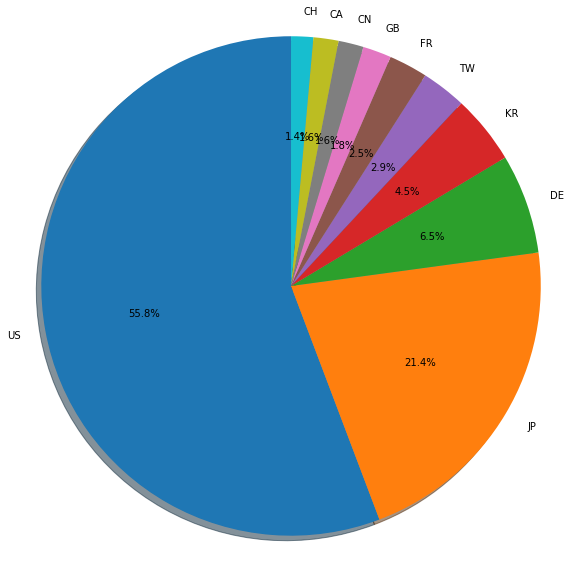

In [250]:
x = dict(100 * assignee_country_counts[:10] / assignee_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## Plot the pie-chart of the patent distribution per inventor

In [253]:
inventor_country_counts = ddf.groupby('number')['country_inventor'].first().value_counts().compute()
inventor_country_counts

US    3874231
JP    1319830
DE     446399
KR     275035
TW     222234
       ...   
CD          1
VS          1
EK          1
BU          1
ER          1
Name: country_inventor, Length: 244, dtype: int64

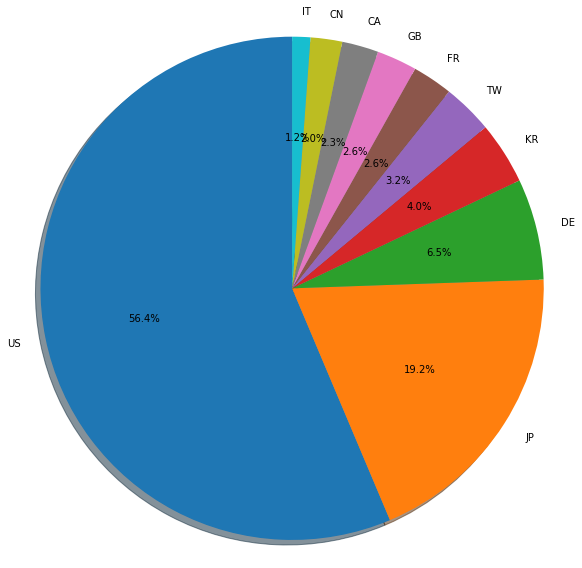

In [254]:
x = dict(100 * inventor_country_counts[:10] / inventor_country_counts.values.sum())


fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(x.values(), labels=x.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()